In [1]:
import os
import glob
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_parquet('/cephfs/users/annawoodard/gene-fusion/fusions.parquet')
pattern = re.compile(r'\^.*')
data['StrippedLeftGene'] = data.LeftGene.str.replace(pattern, '')
data['StrippedRightGene'] = data.RightGene.str.replace(pattern, '')

In [3]:
dupe_samples = [
    'LIB-04604wt',
    'LIB-04626wt',
    'LIB-04662wt',
    'LIB-04629wt',
    'LIB-04609wt',
    'LIB-04660wt',
    'LIB-04623wt',
    'LIB-04607wt',
    'LIB-04630wt',
    'LIB-04622wt',
    'LIB-03328WT',
    'LIB-04661wt'
]
pass_QC = (
    ~data.patient.str.contains('Unknown') &
    ~data.patient.str.contains('K562') &
    ~data.patient.str.contains('WRONG') &
    ~data['sample'].str.contains('|'.join(dupe_samples))
)

print('{} fusions that pass QC; {} fusions that fail QC'.format(
    len(data[pass_QC]['#FusionName']),
    len(data[~pass_QC]['#FusionName'])
    )
)

data = data.loc[pass_QC]

3969 fusions that pass QC; 763 fusions that fail QC


In [4]:
data['#FusionName'].nunique()

1951

minimum FFPM: 0.1


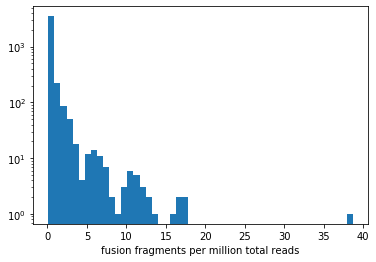

In [5]:
ax = data['FFPM'].hist(bins=50)
ax.set_yscale('log')
ax.grid(False)
ax.set_xlabel('fusion fragments per million total reads')
print('minimum FFPM: {:.1f}'.format(min(data['FFPM'])))

From the STAR-fusion documentation: a filter of 0.1 sum FFPM (meaning at least 1 fusion-supporting rna-seq fragment per 10M total reads) tends to be effective at excluding fusion artifacts. I've required FFPM >= 0.1 here.

Text(0.5, 0, 'Shannon entropy (left breakpoint)')

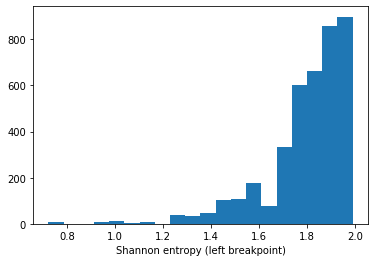

In [6]:
ax = data['LeftBreakEntropy'].hist(bins=20)
ax.grid(False)
ax.set_xlabel('Shannon entropy (left breakpoint)')

Text(0.5, 0, 'Shannon entropy (right breakpoint)')

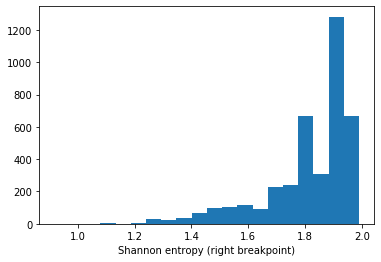

In [7]:
ax = data['RightBreakEntropy'].hist(bins=20)
ax.grid(False)
ax.set_xlabel('Shannon entropy (right breakpoint)')

Above: the Shannon entropy of the 15 exonic bases flanking the breakpoint. From the STAR-fusion documentation: the maximum entropy is 2, representing highest complexity. The lowest would be zero (involving a 15 base mononucleotide run). Low entropy sites should generally be treated as less confident breakpoints.

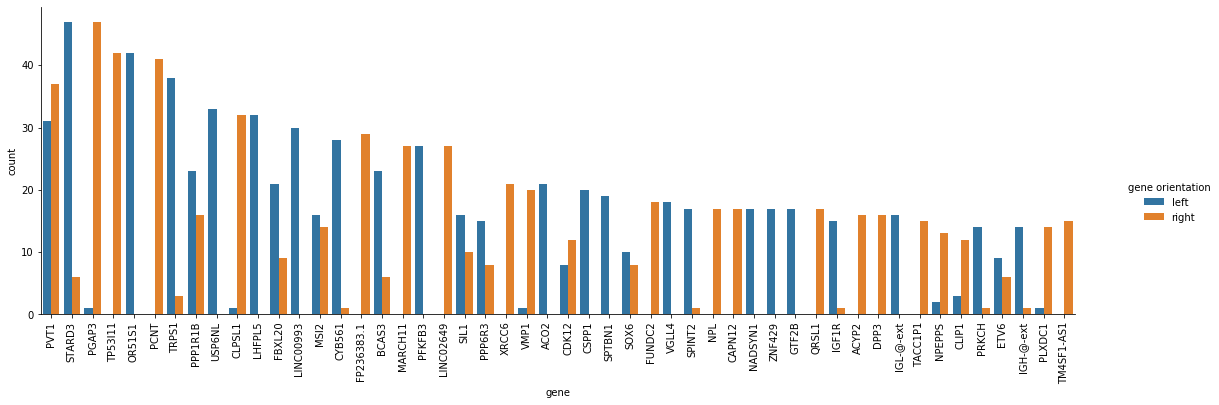

In [8]:
melted_data = pd.melt(data[['StrippedLeftGene', 'StrippedRightGene']])
order = melted_data.value.value_counts().keys().to_list()
g = sns.catplot(x="value", kind="count", hue="variable", data=melted_data, order=order[:50], aspect=3, legend_out=True)
g.set_xticklabels(rotation=90)
g.axes[0,0].set_xlabel('gene')
g._legend.set_title('gene orientation')
g._legend.texts[0].set_text('left')
g._legend.texts[1].set_text('right')

In [9]:
oncokb = pd.read_table('/cephfs/users/annawoodard/gene-fusion/allActionableVariants.txt')
fusion_oncokb = oncokb.loc[oncokb.Alteration.str.contains('Fusion')]

In [10]:
data[(data.StrippedLeftGene.isin(fusion_oncokb['Hugo Symbol'])) | (data.StrippedRightGene.isin(fusion_oncokb['Hugo Symbol']))]['#FusionName'].unique()

array(['BRAF--ADCK2', 'ETV6--NTRK3', 'BCR--ABL1', 'CCT6P3--ABL1',
       'JAK2--LINC01239', 'FGFR3--KRT16P4', 'PDGFRB--PFDN5'], dtype=object)

In [12]:
data[(data.StrippedLeftGene.isin(fusion_oncokb['Hugo Symbol']) | data.StrippedRightGene.isin(fusion_oncokb['Hugo Symbol']))]['#FusionName'].unique()

array(['BRAF--ADCK2', 'ETV6--NTRK3', 'BCR--ABL1', 'CCT6P3--ABL1',
       'JAK2--LINC01239', 'FGFR3--KRT16P4', 'PDGFRB--PFDN5'], dtype=object)

In [13]:
fusion_oncokb[(fusion_oncokb['Hugo Symbol'].isin(data.StrippedLeftGene)) | (fusion_oncokb['Hugo Symbol'].isin(data.StrippedRightGene)) ]

,Isoform,RefSeq,Entrez Gene ID,Hugo Symbol,Alteration,Protein Change,Cancer Type,Level,Drugs(s),PMIDs for drug,Abstracts for drug
7,ENST00000318560,NM_005157.4,25,ABL1,BCR-ABL1 Fusion,BCR-ABL1 Fusion,B-Lymphoblastic Leukemia/Lymphoma,1,"Dasatinib, Imatinib, Ponatinib","11287973, 12200353, 17496201, 20131302, 219311...",Hunger et al. ASH 2017 http://www.bloodjournal...
9,ENST00000318560,NM_005157.4,25,ABL1,BCR-ABL1 Fusion,BCR-ABL1 Fusion,Chronic Myelogenous Leukemia,1,"Bosutinib, Dasatinib, Imatinib, Nilotinib","11287972, 11287973, 12637609, 20525993, 205259...",NaN
40,ENST00000260795,NM_000142.4,2261,FGFR3,Fusions,Fusions,Bladder Cancer,1,Erdafitinib,"26324363, 31340094",NaN
56,ENST00000360948,NM_001012338.2,4916,NTRK3,Fusions,Fusions,All Solid Tumors,1,Larotrectinib,"26216294, 29466156",NaN
62,ENST00000261799,NM_002609.3,5159,PDGFRB,Fusions,Fusions,Myelodysplastic/Myeloproliferative Neoplasms,1,Imatinib,"12181402, 12676775, 14504092, 1516603, 1696015...",NaN
67,ENST00000318560,NM_005157.4,25,ABL1,BCR-ABL1 Fusion,BCR-ABL1 Fusion,B-Lymphoblastic Leukemia/Lymphoma,2A,"Bosutinib, Nilotinib","15071128, 19075254",NaN
130,ENST00000318560,NM_005157.4,25,ABL1,BCR-ABL1 Fusion,BCR-ABL1 Fusion,Chronic Myelogenous Leukemia,3A,Asciminib,NaN,"Mauro, M. et al. Abstract# TPS7081, ASCO 2018 ..."
138,ENST00000288602,NM_004333.4,673,BRAF,Fusions,Fusions,Melanoma,3A,"Cobimetinib, Trametinib","23890088, 24345920, 26072686, 26314551",NaN
141,ENST00000288602,NM_004333.4,673,BRAF,Fusions,Fusions,Ovarian Cancer,3A,"Cobimetinib, Trametinib","23890088, 24345920, 26324360",NaN
151,ENST00000260795,NM_000142.4,2261,FGFR3,Fusions,Fusions,Bladder Cancer,3A,"AZD4547, BGJ398, Debio1347","22837387, 29848605, 30745300",NaN


In [14]:
hr_status = pd.read_csv('/cephfs/users/annawoodard/gene-fusion/WABCS_final_IHC_2019-06-14.csv', dtype=str)

In [15]:
hr_status.columns

Index(['NBCS Barcode', 'WES', 'RNA-seq', 'WGS', 'ER Status', 'ER Allred Score',
       'ER intensity', 'ER % Score', 'PR Status', 'PR Allred Score',
       'PR intensity', 'PR % Score', 'HER2 Status by IHC', 'HER2IHCScore',
       'HER2intensity', 'HER2%Score', 'HER2 amplified', 'focal',
       'copy number (adj. purity/ploidy)', 'Ploidy17p', 'Ploidy17q',
       'CN/ploidy17p ratio', 'CN/ploidy17q ratio', 'Final HR status',
       'Final HER2 Status', 'Unnamed: 25', 'NBCS Barcode.1', 'ER Status.1',
       'ER Allred Score.1', 'ER intensity.1', 'ER % score', 'PR Status.1',
       'PR Allred Score.1', 'PR intensity.1', 'PR % score', 'HER2 Status',
       'HER2 Score', 'HER2 % score', 'ER Status.2', 'ER Allred Score.2',
       'ER intensity.2', 'ER % Score.1', 'PR Status.2', 'PR Allred Score.2',
       'PR intensity.2', 'PR % Score.1', 'HER2 Status.1', 'HER2 IHC Score',
       'HER2 intensity', 'HER2 % Score', 'Unnamed: 50', 'Unnamed: 51',
       'NBCS Barcode.2', 'Collection Site', 'Date

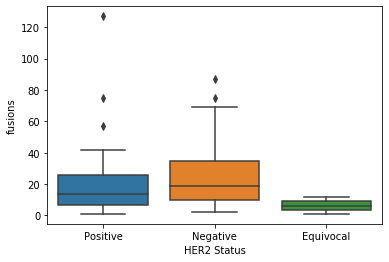

In [16]:
patients = data['patient'].unique()
fusion_counts = pd.DataFrame(data={
    'patient': patients,
    'fusions': [data[data['patient'] == p]['#FusionName'].nunique() for p in patients],
    'ER Status': [hr_status[hr_status['NBCS Barcode'] == p]['ER Status'].iloc[0] for p in patients],
    'PR Status': [hr_status[hr_status['NBCS Barcode'] == p]['PR Status'].iloc[0] for p in patients],
    'HER2 Status': [hr_status[hr_status['NBCS Barcode'] == p]['Final HER2 Status'].iloc[0] for p in patients]
    }
)

ax = sns.boxplot(x='HER2 Status', y='fusions', data=fusion_counts)

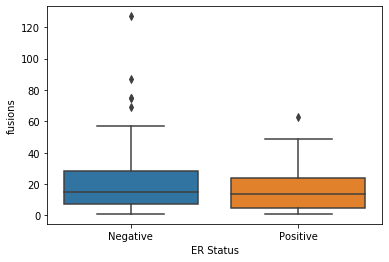

In [17]:
ax = sns.boxplot(x='ER Status', y='fusions', data=fusion_counts)


1

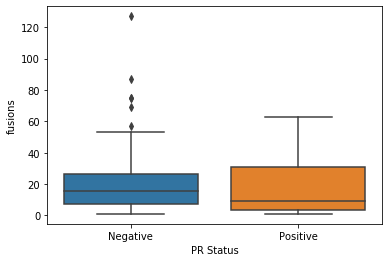

In [18]:
ax = sns.boxplot(x='PR Status', y='fusions', data=fusion_counts)
max(fusion_counts.fusions)
min(fusion_counts.fusions)

In [19]:
subtype = []
for p in patients:
    subtype += [
        'ER{}/PR{}/HER2{}'.format(
        hr_status[hr_status['NBCS Barcode'] == p]['ER Status'].iloc[0],
        hr_status[hr_status['NBCS Barcode'] == p]['PR Status'].iloc[0],
        hr_status[hr_status['NBCS Barcode'] == p]['Final HER2 Status'].iloc[0]
        )
    ]
fusion_counts = pd.DataFrame(data={
    'patient': patients,
    'fusions': [data[data['patient'] == p]['#FusionName'].nunique() for p in patients],
    'subtype': subtype
    }
)

In [20]:
len(patients)

97

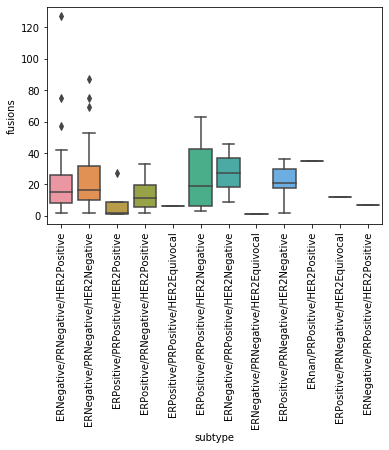

In [21]:
ax = sns.boxplot(x='subtype', y='fusions', data=fusion_counts)
for l in ax.get_xticklabels():
    l.set_rotation(90)

In [22]:
fusion_counts.subtype.value_counts()

ERNegative/PRNegative/HER2Negative     34
ERNegative/PRNegative/HER2Positive     29
ERPositive/PRNegative/HER2Positive     10
ERPositive/PRNegative/HER2Negative      7
ERPositive/PRPositive/HER2Negative      6
ERPositive/PRPositive/HER2Positive      4
ERNegative/PRPositive/HER2Negative      2
ERNegative/PRNegative/HER2Equivocal     1
ERPositive/PRPositive/HER2Equivocal     1
ERPositive/PRNegative/HER2Equivocal     1
ERNegative/PRPositive/HER2Positive      1
ERnan/PRPositive/HER2Positive           1
Name: subtype, dtype: int64

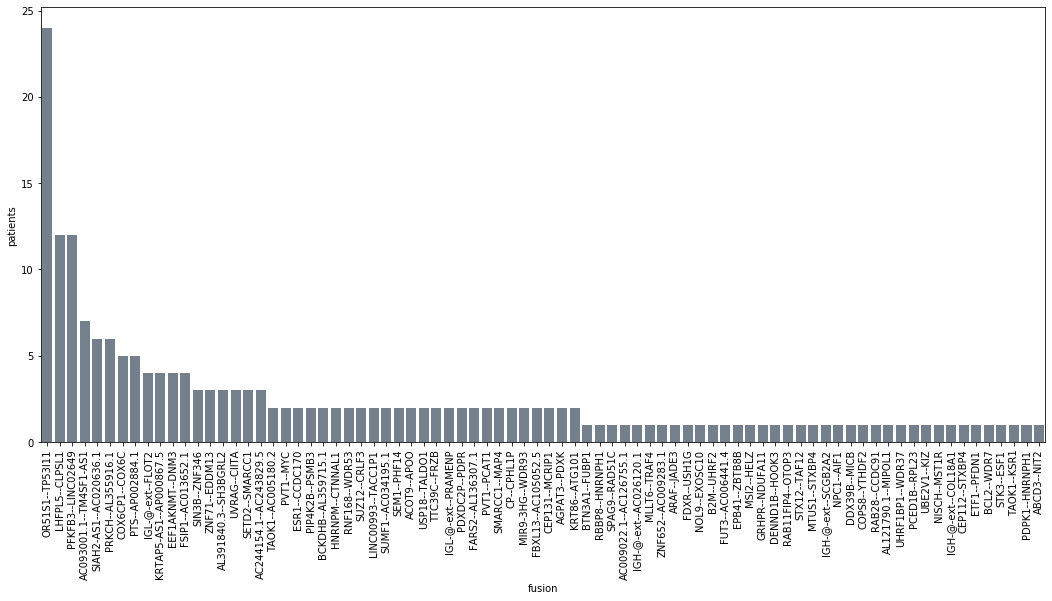

In [23]:
fusions = data['#FusionName'].unique()
patient_counts = pd.DataFrame(data={
    'fusion': fusions,
    'count': [len(data[data['#FusionName'] == fusion]['patient'].unique()) for fusion in fusions]
    }
)
order = patient_counts.sort_values(['count'], ascending=False)['fusion']
fg = plt.figure(figsize=(18, 8))
ax = sns.barplot(x='fusion', y='count', data=patient_counts, color='slategrey', order=order[:80])
ax.set_ylabel('patients')
for l in ax.get_xticklabels():
    l.set_rotation(90)

In [36]:
data[data['#FusionName'] == 'OR51S1--TP53I11']

,#FusionName,JunctionReadCount,SpanningFragCount,SpliceType,LeftGene,LeftBreakpoint,RightGene,RightBreakpoint,JunctionReads,SpanningFrags,...,LeftBreakDinuc,LeftBreakEntropy,RightBreakDinuc,RightBreakEntropy,annots,sample,lane,patient,StrippedLeftGene,StrippedRightGene
7,OR51S1--TP53I11,3,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30445:134:C636BACXX:3:1309:15054:802...,.,...,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-03335WT,L003,N010898,OR51S1,TP53I11
6,OR51S1--TP53I11,3,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30445:134:C636BACXX:4:2203:16759:639...,.,...,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-03335WT,L004,N010898,OR51S1,TP53I11
3,OR51S1--TP53I11,4,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30445:153:C8755ANXX:7:1103:10221:694...,.,...,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-04590wt,L007,NWRONGID_WAS_N011024,OR51S1,TP53I11
3,OR51S1--TP53I11,4,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30445:153:C8755ANXX:8:2314:3296:8361...,.,...,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-04590wt,L008,NWRONGID_WAS_N011024,OR51S1,TP53I11
11,OR51S1--TP53I11,7,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30529:128:C7842ANXX:7:2308:19619:713...,.,...,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-04658wt,L007,L000050,OR51S1,TP53I11
10,OR51S1--TP53I11,7,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30529:128:C7842ANXX:8:2201:9540:9594...,.,...,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-04658wt,L008,L000050,OR51S1,TP53I11
12,OR51S1--TP53I11,4,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30529:128:C7842ANXX:5:2311:7781:7890...,.,...,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-04658wt,L005,L000050,OR51S1,TP53I11
10,OR51S1--TP53I11,7,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30529:128:C7842ANXX:6:1312:5021:1875...,.,...,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-04658wt,L006,L000050,OR51S1,TP53I11
2,OR51S1--TP53I11,3,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30529:128:C7842ANXX:7:2101:11763:866...,.,...,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-04660wt,L007,N010879,OR51S1,TP53I11
16,OR51S1--TP53I11,6,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30529:156:C95L0ANXX:2:1304:13654:650...,.,...,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-008195wt,L002,N011070,OR51S1,TP53I11


In [25]:
cosmic = pd.read_table('/cephfs/users/annawoodard/gene-fusion/CosmicFusionExport.tsv')

In [27]:
cosmic.columns

Index(['Sample ID', 'Sample name', 'Primary site', 'Site subtype 1',
       'Site subtype 2', 'Site subtype 3', 'Primary histology',
       'Histology subtype 1', 'Histology subtype 2', 'Histology subtype 3',
       'Fusion ID', 'Translocation Name', '5' Chromosome',
       '5' Genome start from', '5' Genome start to', '5' Genome stop from',
       '5' Genome stop to', '5' Strand', '3' Chromosome',
       '3' Genome start from', '3' Genome start to', '3' Genome stop from',
       '3' Genome stop to', '3' Strand', 'Fusion type', 'Pubmed_PMID'],
      dtype='object')

In [29]:
cosmic.iloc[0]

Sample ID                                                          749711
Sample name                                                       HCC1187
Primary site                                                       breast
Site subtype 1                                                         NS
Site subtype 2                                                         NS
Site subtype 3                                                         NS
Primary histology                                               carcinoma
Histology subtype 1                                      ductal_carcinoma
Histology subtype 2                                                    NS
Histology subtype 3                                                    NS
Fusion ID                                                             665
Translocation Name      ENST00000360863.10(RGS22):r.1_3555_ENST0000036...
5' Chromosome                                                           8
5' Genome start from                  

In [30]:
data.iloc[0]

#FusionName                                              ITGB6--RBMS1P1
JunctionReadCount                                                    40
SpanningFragCount                                                     7
SpliceType                                          INCL_NON_REF_SPLICE
LeftGene                                       ITGB6^ENSG00000115221.12
LeftBreakpoint                                         chr2:160169212:-
RightGene                                     RBMS1P1^ENSG00000225422.4
RightBreakpoint                                        chr12:66234891:-
JunctionReads         NRUSCA-WDL30445:134:C636BACXX:3:2105:5948:2792...
SpanningFrags         NRUSCA-WDL30445:134:C636BACXX:3:2210:4275:4746...
LargeAnchorSupport                                             YES_LDAS
FFPM                                                             7.0703
LeftBreakDinuc                                                       GT
LeftBreakEntropy                                                

In [31]:
int(9.99819e+07)

99981900

In [32]:
cosmic

,Sample ID,Sample name,Primary site,Site subtype 1,Site subtype 2,Site subtype 3,Primary histology,Histology subtype 1,Histology subtype 2,Histology subtype 3,...,5' Genome stop to,5' Strand,3' Chromosome,3' Genome start from,3' Genome start to,3' Genome stop from,3' Genome stop to,3' Strand,Fusion type,Pubmed_PMID
0,749711,HCC1187,breast,NS,NS,NS,carcinoma,ductal_carcinoma,NS,NS,...,100106116.0,-,1.0,114944339.0,114944339.0,114995367.0,114995367.0,+,Inferred Breakpoint,20033038
1,749711,HCC1187,breast,NS,NS,NS,carcinoma,ductal_carcinoma,NS,NS,...,100106116.0,-,1.0,114944339.0,114944339.0,114995367.0,114995367.0,+,Observed mRNA,20033038
2,749711,HCC1187,breast,NS,NS,NS,carcinoma,ductal_carcinoma,NS,NS,...,129606818.0,-,3.0,129647792.0,129647792.0,129671264.0,129671264.0,-,Inferred Breakpoint,20033038
3,749711,HCC1187,breast,NS,NS,NS,carcinoma,ductal_carcinoma,NS,NS,...,129606818.0,-,3.0,129647792.0,129647792.0,129671264.0,129671264.0,-,Observed mRNA,20033038
4,749711,HCC1187,breast,NS,NS,NS,carcinoma,ductal_carcinoma,NS,NS,...,6741751.0,+,8.0,6642994.0,6642994.0,6648504.0,6648504.0,+,Inferred Breakpoint,20033038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86239,2772929,2772929,urinary_tract,bladder,NS,NS,carcinoma,transitional_cell_carcinoma,NS,NS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30220708
86240,2772930,2772930,urinary_tract,bladder,NS,NS,carcinoma,transitional_cell_carcinoma,NS,NS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30220708
86241,2772931,2772931,urinary_tract,bladder,NS,NS,carcinoma,transitional_cell_carcinoma,NS,NS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30220708
86242,2772932,2772932,urinary_tract,bladder,NS,NS,carcinoma,transitional_cell_carcinoma,NS,NS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30220708
